[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Grabowski_and_Pawlowska_2023/figure_3.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Grabowski_and_Pawlowska_2023/figure_3.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Grabowski_and_Pawlowska_2023/figure_3.ipynb)

### based on Fig. 3 from Wojciech Grabowski and Hanna Pawlowska 2023 (Geophysical Research Letters 50(3)) 'Adiabatic Evolution of Cloud Droplet Spectral Width: A New Look at an Old Problem'

https://doi.org/10.1029/2022GL101917

In [1]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
import numpy as np
from matplotlib import pyplot, ticker
from open_atmos_jupyter_utils import show_plot

from PySDM.physics import si, in_unit
from PySDM.products import ParcelDisplacement, ActivatedParticleConcentration, MeanVolumeRadius, AreaStandardDeviation
from PySDM_examples.Grabowski_and_Pawlowska_2023 import Settings, Simulation

In [3]:
products=(
    ParcelDisplacement(name='z'),
    ActivatedParticleConcentration(name= 'n_act', count_activated=True, count_unactivated=False, stp=True),
    MeanVolumeRadius(name= 'r_vol', count_activated=True, count_unactivated=False),
    AreaStandardDeviation(name='area_std', count_activated=True, count_unactivated=False),
)
vertical_velocity=("0.25", "1", "4")
output = { velocity_m_s:
    {
        case: Simulation(Settings(
            vertical_velocity=float(velocity_m_s) * si.m / si.s,
            dt=1 * si.s if 'CI' not in os.environ else 50 * si.s,
            n_sd=200 if 'CI' not in os.environ else 10,
            aerosol=case
        ), products=products).run()
        for case in ("pristine", "polluted")
    }
    for velocity_m_s in vertical_velocity
}
legend = [velocity_m_s +' m/s' for velocity_m_s in vertical_velocity]

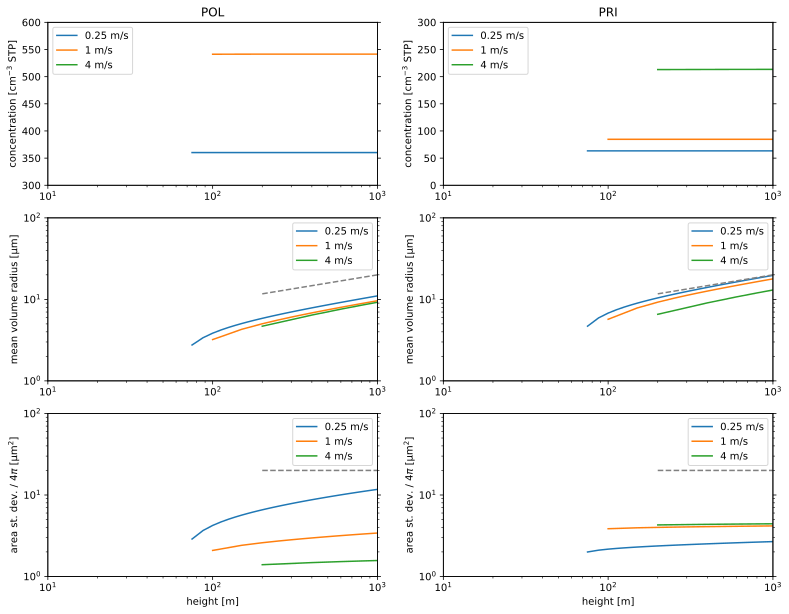

In [4]:
fig, axs = pyplot.subplots(3, 2, figsize=(13, 10))
axN1, axN2, axR1, axR2, axA1, axA2 = axs[0,0], axs[0,1], axs[1,0], axs[1,1], axs[2,0], axs[2,1]

for i, aerosol in enumerate(("polluted", "pristine")):
    for w in vertical_velocity:
        r = np.array(output[w][aerosol]['products']['r_vol'])
        n = np.array(output[w][aerosol]['products']['n_act'])
        a = np.array(output[w][aerosol]['products']['area_std'])/(4 * np.pi)
        z = np.array(output[w][aerosol]['products']['z'])
        axs[1, i].plot(z, np.where(r>2*si.um, in_unit(r, si.um), np.nan))
        axs[0, i].plot(z, np.where(r>2*si.um, in_unit(n, si.cm**-3), np.nan))
        axs[2, i].plot(z, np.where(r>2*si.um, in_unit(a, si.um**2), np.nan))
    z_last = z
    axs[1,i].plot(
        z_last,
        np.where(r>2*si.um, 2 * z_last**(1/3), np.nan),
        color='grey',
        linestyle='--'
    )
    axs[2,i].plot(
        z_last,
        np.where(r>2*si.um, 20, np.nan),
        color='grey',
        linestyle='--'
    )

for ax in (axN1, axN2, axR1, axR2, axA1, axA2):
    ax.set_xlim(10, 1000)
    ax.set_xscale('log')
    ax.legend(legend)
for ax in [axR1,axR2]:
    ax.set_ylabel('mean volume radius [μm]')
for ax in [axN1,axN2]:
    ax.set_ylabel('concentration [cm$^{-3}$ STP]')
for ax in [axA1,axA2]:
    ax.set_xlabel('height [m]')
    ax.set_ylabel(r'area st. dev. / 4$\pi$ [μm$^2$]')
    
axN1_, axN2_, axR1_, axR2_, axA1_, axA2_ = axN1.twinx(), axN2.twinx(), axR1.twinx(), axR2.twinx(), axA1.twinx(), axA2.twinx()
for ax in (axR1, axR2, axR1_, axR2_, axA1, axA2, axA1_, axA2_):
    ax.set_yscale('log')
    ax.set_ylim(1, 100)
for ax in (axN1, axN1_):
    ax.set_ylim(300, 600)
for ax in (axN2, axN2_):
    ax.set_ylim(0, 300)
axN1.set_title('POL')
axN2.set_title('PRI')
for ax in (axN1_, axN2_, axR1_, axR2_, axA1_, axA2_):
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
show_plot("fig3.pdf")